In [1]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf
from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

<h2> GAN - Music Generation

In [2]:
from keras.preprocessing import image
from keras.applications.xception import preprocess_input, decode_predictions
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from keras.utils.vis_utils import model_to_dot
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
from IPython.display import display
from keras.utils.vis_utils import plot_model

In [3]:
def grab_image(img_path):
    img = image.load_img(img_path, color_mode="grayscale", target_size=(106,106))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [4]:
#read in midi images
X = np.concatenate([grab_image('./midi_images/%s'%(filename)) for filename in os.listdir("./midi_images/") if filename.endswith(".png")])

In [5]:
x_train = X
#all real images have a 1 label
y_train = np.ones((X.shape[0], 1))

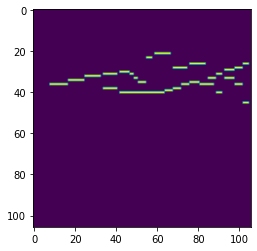

In [6]:
plt.imshow(image.array_to_img(X[9,:,:,:]))
plt.show()

In [7]:
img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
channels = x_train.shape[3]
img_shape = (img_rows, img_cols, channels)
num_classes = len(np.unique(y_train))+1
latent_dim = 100
img_shape

(106, 106, 1)

In [8]:
# Generator
noise = keras.layers.Input(shape=(latent_dim,))

label = keras.layers.Input(shape=(1,), dtype='int32')
label_embedding = keras.layers.Embedding(num_classes, latent_dim)(label)
label_embedding = keras.layers.Flatten()(label_embedding)

generator_input = keras.layers.multiply([noise, label_embedding])

generator_hidden = keras.layers.Dense(128 * 52 * 52, # Reshapable
                                      activation='relu',
                                      input_dim=latent_dim)(generator_input)
generator_hidden = keras.layers.Reshape((52, 52, 128))(generator_hidden)
generator_hidden = keras.layers.BatchNormalization(momentum=0.8)(generator_hidden)
generator_hidden = keras.layers.Conv2DTranspose(64,
                                                kernel_size=(4,4),
                                                strides=(2,2),
                                                activation='relu')(generator_hidden)

generator_hidden = keras.layers.BatchNormalization(momentum=0.8)(generator_hidden)
g_image = keras.layers.Conv2DTranspose(channels, 
                                       kernel_size=(7,7),
                                       padding='same',
                                       activation='tanh')(generator_hidden)

generator = keras.Model([noise, label], g_image, name='Generator')

2022-04-30 01:10:48.897998: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-30 01:10:48.898158: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-30 01:10:48.898276: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-efm2w): /proc/driver/nvidia/version does not exist
2022-04-30 01:10:48.899281: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# Discriminator
d_image = keras.layers.Input(shape=img_shape)

# Hidden layers
discriminator_hidden = keras.layers.Conv2D(16, kernel_size=(3,3), strides=(2,2),padding='same')(d_image)
discriminator_hidden = keras.layers.LeakyReLU(alpha=0.2)(discriminator_hidden)
discriminator_hidden = keras.layers.Dropout(0.25)(discriminator_hidden)
discriminator_hidden = keras.layers.Conv2D(16, kernel_size=(3,3), strides=(2,2), padding='same')(discriminator_hidden)
#discriminator_hidden = keras.layers.ZeroPadding2D(padding=((0,1),(0,1)))(discriminator_hidden)
discriminator_hidden = keras.layers.LeakyReLU(alpha=0.2)(discriminator_hidden)
discriminator_hidden = keras.layers.Dropout(0.25)(discriminator_hidden)
discriminator_hidden = keras.layers.LeakyReLU(alpha=0.2)(discriminator_hidden)
#discriminator_hidden = keras.layers.Dropout(0.25)(discriminator_hidden)
discriminator_hidden = keras.layers.Flatten()(discriminator_hidden)
#discriminator_hidden = keras.layers.BatchNormalization(momentum=0.8)(discriminator_hidden)
discriminator_hidden = keras.layers.Dropout(0.25)(discriminator_hidden)

target_label = keras.layers.Dense(1, activation=keras.activations.sigmoid)(discriminator_hidden)

# Finalize the model
discriminator = keras.Model(d_image, target_label, name="Discriminator")
discriminator.compile(loss=keras.losses.BinaryCrossentropy(),
                      optimizer=keras.optimizers.Adam(0.0002,0.5),
                      metrics=[keras.metrics.BinaryAccuracy()])

In [10]:
#keras.utils.plot_model(generator, show_shapes=True, expand_nested=True)

In [11]:
# Combined model...

combined_model_inputs = [keras.layers.Input(shape=x[1:]) for x in generator.input_shape]
generator_output = generator(combined_model_inputs)
# Turn off learning for discriminator...
discriminator.trainable = False

target_label = discriminator(generator_output) # g_image = generator output layer
# Combined model now takes generator inputs and has discriminator outputs...
combined = keras.Model(combined_model_inputs,target_label)
combined.summary
combined.compile(loss=keras.losses.BinaryCrossentropy(),
                 optimizer=keras.optimizers.Adam(0.0002,0.5))

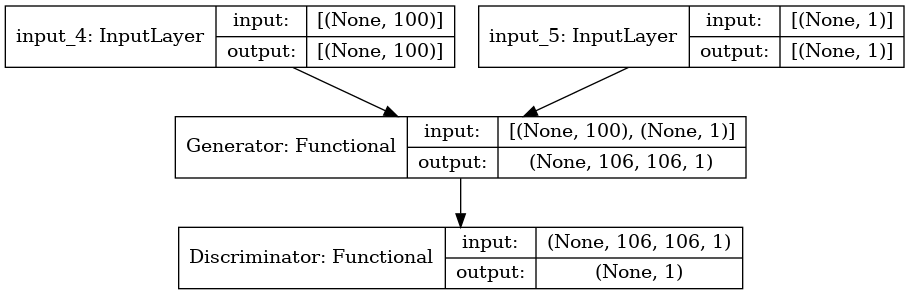

In [12]:
keras.utils.plot_model(combined, show_shapes=True, expand_nested=False)

In [13]:
# Training Parameters
batch_size = 16
half_batch_size = int(batch_size/2)

# Keep track of discriminatory loss[0], disciminator accuracy[1] and generator loss[2]
history = [[],[],[]]

In [14]:
%%time
# Perform some number of batches...
batches = 300
for batch in range(batches):
 # Training the DISCRIMINATOR
 # REAL images
 idx = np.random.randint(0, x_train.shape[0], half_batch_size)
 real_images = x_train[idx]
 image_labels = y_train[idx]

 # FAKE images
 noise = np.random.normal(-1, 1, (half_batch_size, 100))
 sampled_labels = np.ones((half_batch_size, 1))
 generated_images = generator.predict([noise, sampled_labels])

 # Assign the fake images to the "fake class"
 fake_labels = np.zeros(half_batch_size).reshape(-1, 1)

 # Train the discriminator - Two groups
 d_loss_real = discriminator.train_on_batch(real_images, image_labels)
 d_loss_fake = discriminator.train_on_batch(generated_images, fake_labels)
 
 # "overall" loss/accuracy for the discriminator  
 d_loss = np.add(d_loss_real, d_loss_fake) / 2.0

 # Training the generator...
 noise = np.random.normal(-1, 1, (batch_size, 100))

 # calling these real images - try to fake-out the discriminator.
 #Setting the target as if the generated images were real (1)
 sampled_labels = np.ones((batch_size, 1))
 
 # Train the generator
 g_loss = combined.train_on_batch([noise, sampled_labels], sampled_labels)
 
 history[0] += [d_loss[0]]
 history[1] += [d_loss[1]]
 history[2] += [g_loss]
    
 # progress indicator
 print("\r%d [Disc. Loss: %f, Disc. Accuracy: %.2f%%] [Gen. Loss: %f]"%(batch, d_loss[0], 100*d_loss[1], g_loss), end='')

2022-04-30 01:10:52.705754: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


299 [Disc. Loss: 0.898633, Disc. Accuracy: 18.75%] [Gen. Loss: 0.624141]CPU times: user 1h 27min 12s, sys: 10min 14s, total: 1h 37min 27s
Wall time: 10min 2s


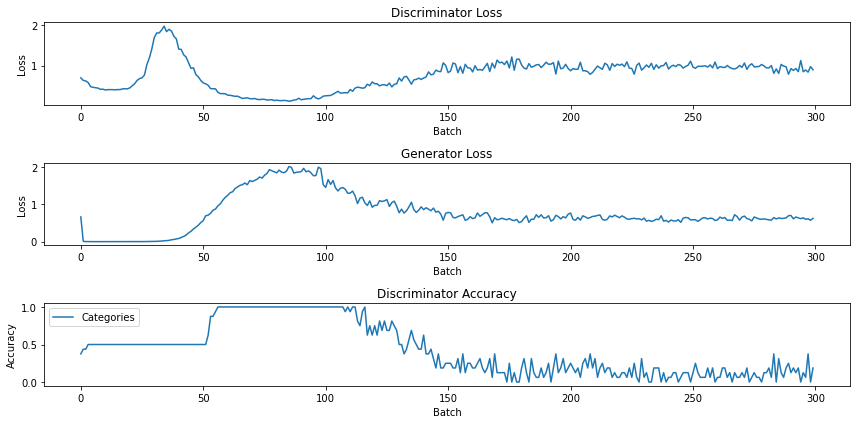

In [15]:
# Plot training history...
plt.figure(1,figsize=(12,6))
plt.subplot(311)
plt.plot(history[0])
plt.title('Discriminator Loss')
plt.ylabel('Loss')
plt.xlabel('Batch')
plt.subplot(312)
plt.plot(history[2])
plt.title('Generator Loss')
plt.ylabel('Loss')
plt.xlabel('Batch')
plt.subplot(313)
plt.plot(history[1])
plt.title('Discriminator Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Batch')
plt.legend(['Categories'], loc='upper left')
plt.tight_layout()
plt.show() 

In [27]:
## Testing
r, c = 10, 10
noise = np.random.normal(-1, 1, (r * c, 100))
print(noise.shape)
sampled_labels = np.ones((100, 1))
# Make some fakes!
generated_images = generator.predict([noise, sampled_labels])
# Plot them..

(100, 100)


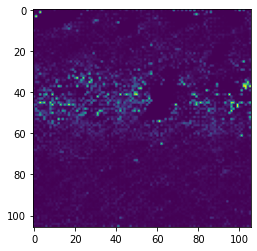

In [28]:
plt.imshow(image.array_to_img(generated_images[98,:,:,:]))
plt.show()

In [29]:
imageSave = image.array_to_img(generated_images[11,:,:,:])

In [30]:
imageSave = imageSave.save('composition.png')